In [1]:
import subprocess
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import cumfreq
from scipy.interpolate import make_interp_spli5ne, BSpline
from scipy.interpolate import interp1d
from dataclasses import dataclass
from scipy.stats import gaussian_kde
from adjustText import adjust_text
import os
import itertools

ModuleNotFoundError: No module named 'numpy'

In [81]:
SIM = "../dpm-simulator/dpm_simulator"
#SIM = "dpm-simulator/dpm_simulator_sleep"
PSM = "../dpm-simulator/example/psm.txt"
WL1 = "../workloads/workload_1.txt"
WL2 = "../workloads/workload_2.txt"
LOWER_LIMIT = 0
UPPER_LIMIT = 200
%matplotlib inline

In [82]:
@dataclass
class WorkloadStats:
    active_time: float
    inactive_time: float
    time_run: float
    time_idle: float
    time_sleep: float
    time_waiting: float
    time_transitions: float
    total_transitions: float
    energy_transitions: float
    energy_total_no_dpm: float
    energy_total_dpm: float

    def saved_energy(self):
        return self.energy_total_no_dpm - self.energy_total_dpm
    def saved_energy_perc(self):
        return (self.energy_total_no_dpm - self.energy_total_dpm) * 100 / self.energy_total_no_dpm
    def power_consumed(self):
        return self.energy_total_dpm

In [83]:
def extract(pattern, output):
    match = re.search(pattern, output, re.IGNORECASE)
    if not match:
        print(f"Cannot find match for {pattern}")
        exit(-1)

    return float(match.group(1))

#incative parameter wants i(idle) or s(sleep) to identify the inactive status we want to use
def dpm_sim_t(timeout, workload, inactive):

    if(inactive != 'i' and inactive != 's'):
        print(f"Cannot find meanings for {inactive} - i or s has to be inserted")
        exit(-1)

    args = [SIM, "-t"+inactive, str(timeout), "-psm", PSM, "-wl", workload]
    status = subprocess.run(args, stdout=subprocess.PIPE)

    if status.returncode != 0:
        print("There was an error")
        exit(-1)

    return extract_data_workload(status)

def dpm_sim_ha(sleep_threshold, idle_threshold, workload):

    args = [SIM, "-ha", str(sleep_threshold), str(idle_threshold), "-psm", PSM, "-wl", workload]
    status = subprocess.run(args, stdout=subprocess.PIPE)

    if status.returncode != 0:
        print("There was an error")
        exit(-1)

    return extract_data_workload(status)

def extract_data_workload(stdout_bin):
    stdout = stdout_bin.stdout.decode("utf-8")

    active_time = extract(r"Active time in profile = ([0-9\.]+)", stdout)
    inactive_time = extract(r"Inactive time in profile = ([0-9\.]+)", stdout)
    time_run = extract(r"Total time in state Run = ([0-9\.]+)", stdout)
    time_idle = extract(r"Total time in state Idle = ([0-9\.]+)", stdout)
    time_sleep = extract(r"Total time in state Sleep = ([0-9\.]+)", stdout)
    time_waiting = extract(r"Timeout waiting time = ([0-9\.]+)", stdout)
    time_transitions = extract(r"Transitions time = ([0-9\.]+)", stdout)
    total_transitions = extract(r"N. of transitions = ([0-9\.]+)", stdout)
    energy_transitions = extract(r"Energy for transitions = ([0-9\.]+)", stdout)
    energy_total_no_dpm = extract(r"Tot. Energy w/o DPM = ([0-9\.]+)", stdout)
    energy_total_dpm = extract(r"Tot. Energy w DPM = ([0-9\.]+)", stdout)

    workload_stats = WorkloadStats(
        active_time,
        inactive_time,
        time_run,
        time_idle,
        time_sleep,
        time_waiting,
        time_transitions,
        total_transitions,
        energy_transitions,
        energy_total_no_dpm,
        energy_total_dpm,
    )

    return workload_stats

In [84]:
# === Nuove funzioni per il calcolo e il plot della PDF ===

def idle_list(workload_points):
    """
    Data una lista di punti di workload, dove ogni punto è [start_time, duration],
    calcola i periodi di inattività (idle times) tra le attività.
    """
    idle_times = []
    for i in range(len(workload_points) - 1):
        # Se il primo task non parte da 0, consideriamo il tempo iniziale come idle
        if i == 0 and workload_points[i][0] > 0:
            idle_times.append(workload_points[i][0])
        end_time = workload_points[i][0] + workload_points[i][1]
        next_arrival = workload_points[i + 1][0]
        idle_time = next_arrival - end_time
        if idle_time > 0:
            idle_times.append(idle_time)
        elif idle_time < 0:
            print("Idle time is negative")
    return np.array(idle_times)


In [85]:
def load_workload(filename):
    """
    Legge il file di workload in cui ogni riga contiene:
        arrivaltime duration
    e restituisce una lista di punti: [[arrivaltime, duration], ...]
    """
    workload_points = []
    with open(filename, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 2:
                try:
                    arrival = float(parts[0])
                    duration = float(parts[1])
                    workload_points.append([arrival, duration])
                except ValueError:
                    print(f"Valore non valido nella riga: {line}")
    return workload_points

In [86]:
def extract_energy_saved(output):
    """
    Estrae dall'output del simulatore i valori energetici e restituisce:
    energy_saved = Tot. Energy w/o DPM - Tot. Energy w DPM.
    """
    pattern = r"Tot\. Energy w/o DPM\s*=\s*([\d\.]+)J,\s*Tot\. Energy w DPM\s*=\s*([\d\.]+)J"
    match = re.search(pattern, output)
    if match:
        energy_no_dpm = float(match.group(1))
        energy_dpm = float(match.group(2))
        return energy_no_dpm - energy_dpm
    else:
        print("Impossibile estrarre i valori energetici dall'output.")
        return None

In [87]:
def cumtrapz_manual(y, x):
    """
    Calcola l'integrazione cumulativa della funzione y(x) usando il metodo dei trapezi.
    Restituisce un array di dimensione len(y) - 1.
    """
    return np.cumsum((y[1:] + y[:-1]) / 2 * np.diff(x))


In [88]:

def compute_pdf_cdf(data, points=1000):
    """
    Calcola la PDF e la CDF stimate tramite KDE per i dati in 'data'.
    Restituisce:
    x_vals: ascisse (vettore)
    pdf_vals: valori di densità f(x)
    cdf_vals: valori di distribuzione cumulativa F(x)
    """
    kde = gaussian_kde(data)
    x_vals = np.linspace(0, max(data)*1.1, points)  # piccolo margine oltre il max
    pdf_vals = kde(x_vals)
    
    cdf_vals = cumtrapz_manual(pdf_vals, x_vals)
    # Aggiungi uno zero iniziale per ottenere lo stesso numero di elementi di x_vals
    cdf_vals = np.insert(cdf_vals, 0, 0)
    # Normalizza la CDF in modo che l'ultimo valore sia 1
    cdf_vals /= cdf_vals[-1]
    return x_vals, pdf_vals, cdf_vals

In [89]:
def plot_power_timeout(policy):
    
    energy_saved = []
    timeout = []
    plt.figure(figsize=(18, 8))
    plt.subplot(1, 2, 1)
    for t in range(LOWER_LIMIT, UPPER_LIMIT):
        workload_stats = dpm_sim_t(timeout=t, workload=WL1, inactive=policy)
        saved = workload_stats.power_consumed()
        print(t)
        energy_saved.append(saved)
        timeout.append(t)

    plt.plot(timeout, energy_saved, label=f'Workload 1', markersize=4, linestyle='-')

    energy_saved = []
    timeout = []
    for t in range(LOWER_LIMIT, UPPER_LIMIT):
        workload_stats = dpm_sim_t(timeout=t, workload=WL2, inactive=policy)
        saved = workload_stats.power_consumed()
        print(t)
        energy_saved.append(saved)
        timeout.append(t)

    plt.plot(timeout, energy_saved, label=f'Workload 2', markersize=4, linestyle='-')

    plt.xlabel('Timeout (s)')
    plt.ylabel('Energy Saved (J)')
    plt.title('Energy Saved vs. Timeout')
    plt.grid()
    plt.legend()
    plt.show()
    plt.savefig(f'../graph/saved_idle_{LOWER_LIMIT}_{UPPER_LIMIT}.png', format="png", dpi=300)


In [90]:
def plot_saved_energy_timeout(policy):
    
    energy_saved = []
    timeout = []
    plt.figure(figsize=(18, 8))
    plt.subplot(1, 2, 1)
    for t in range(LOWER_LIMIT, UPPER_LIMIT):
        workload_stats = dpm_sim_t(timeout=t, workload=WL1, inactive=policy)
        saved = workload_stats.saved_energy_perc()
        print(t)
        energy_saved.append(saved)
        timeout.append(t)

    plt.plot(timeout, energy_saved, label=f'Workload 1', markersize=4, linestyle='-')

    energy_saved = []
    timeout = []
    for t in range(LOWER_LIMIT, UPPER_LIMIT):
        workload_stats = dpm_sim_t(timeout=t, workload=WL2, inactive=policy)
        saved = workload_stats.saved_energy_perc()
        print(t)
        energy_saved.append(saved)
        timeout.append(t)

    plt.plot(timeout, energy_saved, label=f'Workload 2', markersize=4, linestyle='-')

    plt.xlabel('Timeout (s)')
    plt.ylabel('Energy Saved (J)')
    plt.title('Energy Saved vs. Timeout')
    plt.grid()
    plt.legend()
    plt.show()
    plt.savefig(f'../graph/saved_idle_{LOWER_LIMIT}_{UPPER_LIMIT}.png', format="png", dpi=300)

In [91]:
def plot_workload_stats(path):
    workload = open(path, 'r')
    lines = workload.readlines()

    # Prepare time and state lists
    time_points = []
    state_points = []
    current_time = 0

    for line in lines:
        # Add an idle period if there's a gap before the next run period
        start_time, duration = line.split(' ', 1)
        start_time = int(start_time)
        duration = int(duration)

        if start_time > current_time:
            time_points.append(current_time)
            state_points.append(0)  # Idle state
            time_points.append(start_time)
            state_points.app
            end(0)  # Idle state

        # Add the run period
        time_points.append(start_time)
        state_points.append(1)  # Run state
        time_points.append(start_time + duration)
        state_points.append(1)  # Run state

        # Update the current time to end of the run period
        current_time = start_time + duration
    print(time_points)
    print(str(time_points[-1]))
        

   # Plot the workload states over time
    plt.figure(figsize=(10, 4))
    plt.step(time_points, state_points, where='post', label="Workload State")
    plt.ylim(-0.1, 1.1)
    print(f'path: {path}, WL1:{WL1}, WL2:{WL2}')
    if path == WL1:
        plt.xlim(0, 600)
    if path == WL2:
        plt.xlim(0, 122224)
    plt.xlabel("Time")
    plt.ylabel("State (1=On, 0=Off)")
    plt.title("Workload On and Off Timeline")
    plt.grid(True)
    plt.legend()
    plt.savefig(f'../graph/workload2.png', format="png", dpi=300)

    plt.show()

In [92]:
def plot_saved_energy_comparison():
    timeouts = range(LOWER_LIMIT, UPPER_LIMIT)
    workloads = [WL1, WL2]
    colors = ['blue', 'green']

    for idx, workload in enumerate(workloads):
        energy_saved_idle = []
        energy_saved_sleep = []

        # Calcolare l'energia salvata per modalità "idle" e "sleep"
        for t in timeouts:
            stats_idle = dpm_sim_t(timeout=t, workload=workload, inactive='i')
            stats_sleep = dpm_sim_t(timeout=t, workload=workload, inactive='s')

            energy_saved_idle.append(stats_idle.saved_energy())
            energy_saved_sleep.append(stats_sleep.saved_energy())

        # Calcolare la differenza tra modalità
        energy_diff = np.array(energy_saved_idle) - np.array(energy_saved_sleep)

        # Plot differenza
        plt.plot(
            timeouts,
            energy_diff,
            label=f'Differenza {workload.split("/")[-1]}',
            color=colors[idx],
            marker='o',
            linestyle='--'
        )

    plt.axhline(0, color='red', linestyle=':', label='Zero Difference')
    plt.xlabel('Timeout (s)')
    plt.ylabel('Differenza Energia Salvata (J)')
    plt.title('Confronto Energia Salvata: Idle vs Sleep')
    plt.legend()
    plt.grid()
    plt.savefig(f'../graph/saved_energy_comparison_{LOWER_LIMIT}_{UPPER_LIMIT}.png', format="png", dpi=300)
    plt.show()


In [93]:
def plot_idle_pdf(path):
    """
    Legge il file workload (con righe nel formato: "start_time duration"),
    calcola i periodi di inattività e plotta la Probability Density Function (PDF)
    tramite una stima di densità kernel con smoothing migliorato.
    """
    with open(path, 'r') as f:
        lines = f.readlines()
    
    workload_points = []
    for line in lines:
        parts = line.split()
        if len(parts) >= 2:
            start_time = int(parts[0])
            duration = int(parts[1])
            workload_points.append([start_time, duration])
    
    if not workload_points:
        print("Nessun punto di workload trovato.")
        return
    
    idle_times = idle_list(workload_points)
    if idle_times.size == 0:
        print("Nessun periodo di inattività calcolato.")
        return

    # Calcola la KDE con bandwidth adattativo
    kde = gaussian_kde(idle_times, bw_method='silverman')  # Metodo di Silverman per il bandwidth
    
    # Estende leggermente il range per una visualizzazione più naturale
    x_start = max(0, min(idle_times) - 1)  # Evita valori negativi
    x_end = max(idle_times) + 1
    x_values = np.linspace(x_start, x_end, 1000)
    
    # Calcola i valori della PDF
    pdf_values = kde(x_values)

    # Plot della PDF
    plt.figure(figsize=(10, 6))
    plt.plot(x_values, pdf_values, color='darkblue', linewidth=2, label="PDF stimata")
    
    # Formattazione del grafico
    plt.xlabel("Inactivity time (ms)", fontsize=12)
    plt.ylabel("Probability density", fontsize=12)
    plt.title("Distribution of the inactivity time", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # Mostra il plot
    plt.tight_layout()
    plt.show()

In [94]:
def plot_break_even_effect(idle_times, T_BE, P_on, P_off, T_tr):
    """
    Mostra come la distribuzione di T_idle incide sul break-even time T_BE.
    Disegna PDF, CDF e calcola probabilità e risparmio energetico atteso.
    """
    x_vals, pdf_vals, cdf_vals = compute_pdf_cdf(idle_times)
    
    # Trova l'indice nel vettore x_vals più vicino a T_BE
    idx_BE = np.searchsorted(x_vals, T_BE)
    if idx_BE >= len(x_vals):
        idx_BE = len(x_vals) - 1
    
    # Probabilità di T_idle > T_BE
    prob_off = 1.0 - cdf_vals[idx_BE]
    
    # Calcolo dell'aspettativa E[(T_idle - T_BE) per T_idle > T_BE]
    # Numeratore = ∫ da T_BE a ∞ (t - T_BE) f(t) dt
    # Denominatore = 1 - F(T_BE)
    if prob_off > 0:
        # Integriamo in modo numerico da idx_BE fino a fine
        dx = x_vals[1] - x_vals[0]
        t_minus = (x_vals[idx_BE:] - T_BE)  # (t - T_BE)
        pdf_slice = pdf_vals[idx_BE:]
        numerator = np.trapz(t_minus * pdf_slice, x_vals[idx_BE:])
        cond_mean = numerator / prob_off
    else:
        cond_mean = 0.0
    
    # Risparmio energetico approssimativo:
    # (P_on - P_off) * prob_off * cond_mean - (P_on - P_off)*T_tr (o un costo più accurato)
    energy_transition = (P_on - P_off) * T_tr
    e_saved = (P_on - P_off) * prob_off * cond_mean - energy_transition
    
    # === Plot ===
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    # Subplot 1: PDF
    axs[0].plot(x_vals, pdf_vals, label="PDF T_idle")
    axs[0].axvline(T_BE, color='r', linestyle='--', label=f"T_BE = {T_BE:.2f}")
    axs[0].set_xlabel("T_idle")
    axs[0].set_ylabel("f(T_idle)")
    axs[0].set_title("(PDF)")
    axs[0].legend()
    axs[0].grid(True)
    plt.xlim(0, 100000)  # Limita l'asse x fino a 100
    
    # Subplot 2: CDF
    axs[1].plot(x_vals, cdf_vals, label="CDF T_idle", color='green')
    axs[1].axvline(T_BE, color='r', linestyle='--', label=f"T_BE = {T_BE:.2f}")
    axs[1].set_xlabel("T_idle")
    axs[1].set_ylabel("F(T_idle)")
    axs[1].set_title("(CDF)")
    axs[1].legend()
    axs[1].grid(True)
    plt.xlim(0, 100000)  # Limita l'asse x fino a 100
    
    # Mostra a schermo qualche informazione
    text_str = (f"Prob. (T_idle > T_BE) = {prob_off:.3f}\n")
                #f"E[T_idle - T_BE | > T_BE] = {cond_mean:.3f}\n"
                #f"E_saved ≈ {e_saved:.3f} (W·ms o altra unità)")
    # Aggiungiamo la stringa di info in un riquadro
    axs[1].text(0.05, 0.5, text_str, transform=axs[1].transAxes,
                fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()


In [95]:
OFF_STATE = "Sleep"
def parse_info(file_path):
    # Dictionary to store the extracted information
    info_dict = {}

    # Open and read the file
    with open(file_path, 'r') as file:
        lines = file.readlines()
        Ptr = 0
        Ttr = 0
        
        # Loop through each line and parse based on pattern
        for line in lines:
            # Split based on ':', commonly used in key-value formats
            if ':' in line:
                name, value = line.split(':', 1)  # Split on the first colon
                if "State" in name:
                    if "State Run" in name:
                        name = "Pon"
                    elif "State "+OFF_STATE in name:
                        name = "Poff"
                    if name == "Poff" or name == "Pon" and "power" in value:
                        label, power = value.split('=', 1)  # Split on the first colon
                        power = power.strip()   
                        power = power[:-2]        # Remove any leading/trailing whitespace
                        info_dict[name] = float(power)         # Store in dictionary
                elif "Run -> "+OFF_STATE+" transition" in name:
                    if OFF_STATE in name:
                        if "energy" in value:
                            energy, time = value.split(',', 1)  # Split on the first colon
                            lab, val = energy.split('=', 1)  # Split on the first colon
                            val = val.strip()
                            en = float(val[:-2])
                            lab, val = time.split('=', 1)  # Split on the first colon
                            val = val.strip()
                            tm = float(val[:-2])
                            Ttr+= tm
                            Ptr+= en/tm
        
        info_dict["Ptr"] = float(Ptr)
        info_dict["Ttr"] = float(Ttr)
                            

    
    return info_dict

In [96]:
# Carica i dati del workload
def load_workload(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    workload_points = []
    for line in lines:
        parts = line.strip().split()
        if len(parts) == 2:
            arrivaltime, duration = map(int, parts)
            workload_points.append([arrivaltime, duration])
    return workload_points

# Esempio di utilizzo
w1_points = load_workload(WL1)
w1_points.sort()
w2_points = load_workload(WL2)
w2_points.sort()
#print("Workload Points:", workload_points)


In [97]:
w1_idle_times = idle_list(w1_points)
w2_idle_times = idle_list(w2_points)   

parsed_info = parse_info('../dpm-simulator/result.txt')
Ttr = parsed_info.get("Ttr")
Pon = parsed_info.get("Pon")
Poff = parsed_info.get("Poff")
Tbe = Ttr  # In questo caso, Tbe = Ttr come definito nella formula corrente

In [98]:
def plot_energy_saved_idle_vs_sleep_both():
    # Definiamo il range di timeout da LOWER_LIMIT a UPPER_LIMIT
    timeouts = range(LOWER_LIMIT, UPPER_LIMIT)
    
    # Creiamo una figura con due sottotrame (una per ciascun workload)
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
    # Lista dei workload: WL1 e WL2
    workloads = [WL1, WL2]
    
    # Loop per ciascun workload
    for idx, workload in enumerate(workloads):
        energy_saved_idle = []
        energy_saved_sleep = []
        
        # Calcola l'energia salvata per ogni timeout per entrambe le policy
        for t in timeouts:
            stats_idle = dpm_sim_t(timeout=t, workload=workload, inactive='i')
            stats_sleep = dpm_sim_t(timeout=t, workload=workload, inactive='s')
            energy_saved_idle.append(stats_idle.saved_energy_perc())
            energy_saved_sleep.append(stats_sleep.saved_energy_perc())
        
        # Seleziona la sottotrama corrente
        ax = axs[idx]
        ax.plot(timeouts, energy_saved_idle, label="Policy Idle", markersize=6, linestyle="-", linewidth=2)
        ax.plot(timeouts, energy_saved_sleep, label="Policy sleep", markersize=6, linestyle="--", linewidth=2)
        
        ax.set_xlabel("Timeout (s)", fontsize=14)  # Oppure "Timeout (ms)" se le unità sono diverse
        ax.set_ylabel("Energy Saved (J)", fontsize=14)
        workload_label = "Workload 1" if idx == 0 else "Workload 2"
        ax.set_title(f"Energy Saved vs Timeout - {workload_label}", fontsize=16)
        ax.legend(fontsize=12)
        ax.grid(True, which="both", linestyle="--", linewidth=0.5)
        ax.set_xlim(LOWER_LIMIT, UPPER_LIMIT)
    
    plt.tight_layout()
    plt.savefig('../graph/energy_saved_idle_vs_sleep_both.png', format='png', dpi=300)
    plt.show()


/tmp/ipykernel_2002/1385999548.py:24: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  numerator = np.trapz(t_minus * pdf_slice, x_vals[idx_BE:])


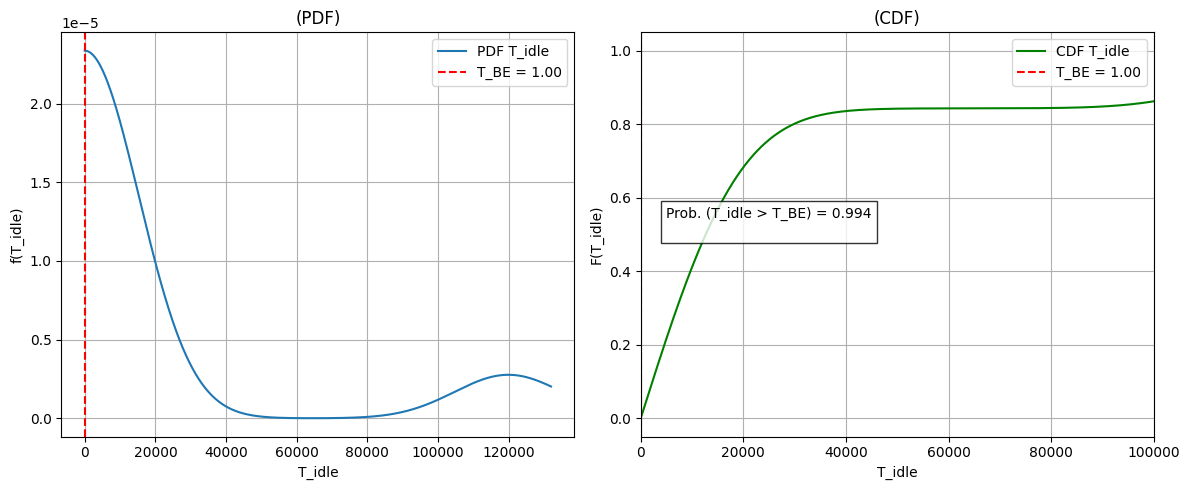

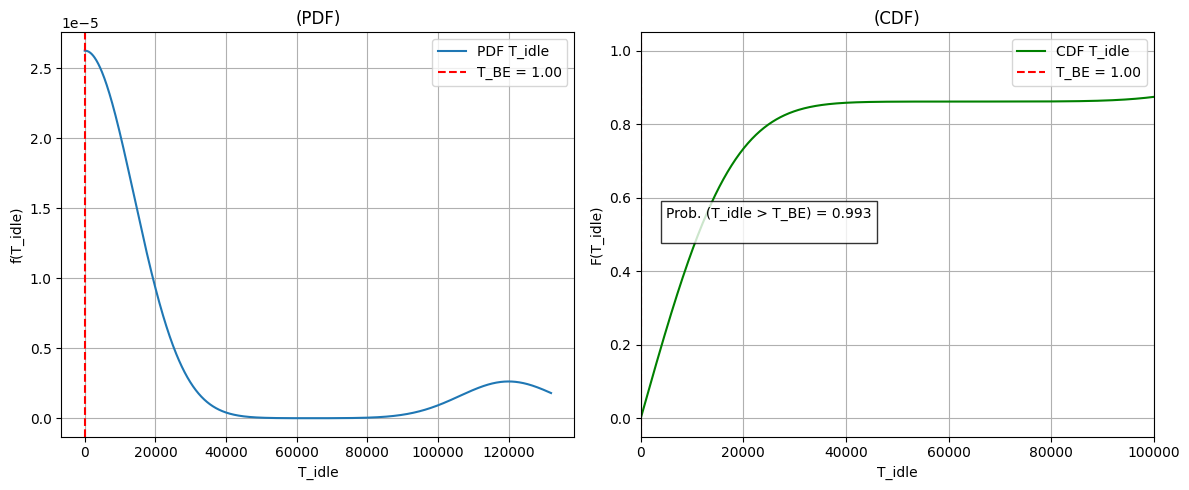

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104


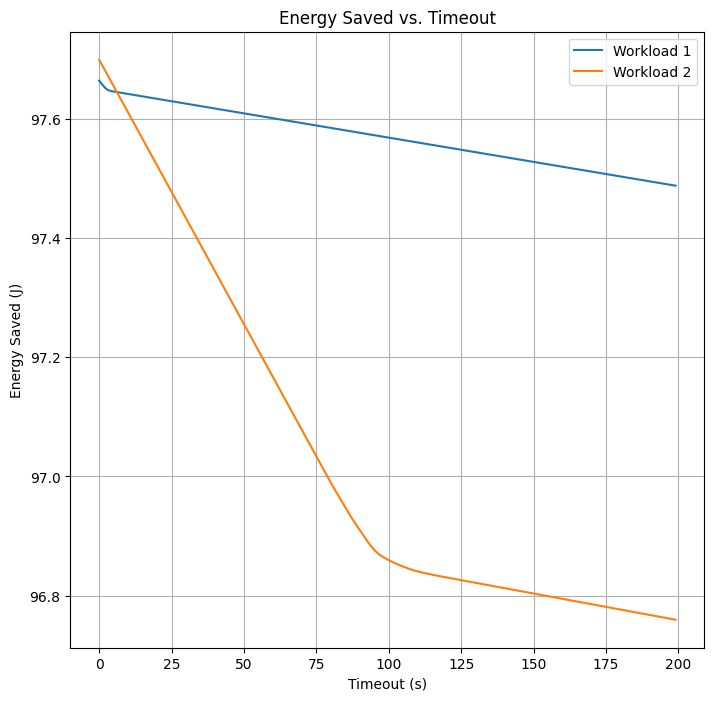

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104


<Figure size 640x480 with 0 Axes>

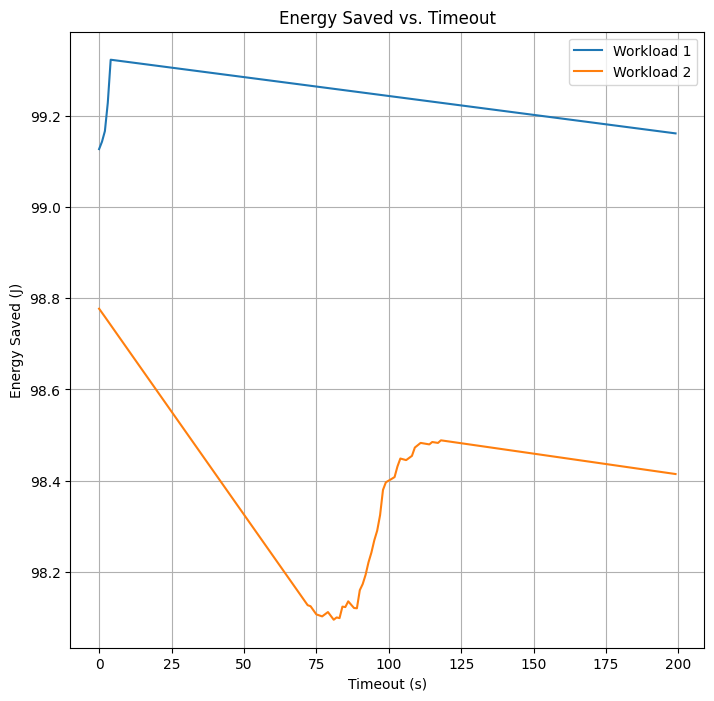

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104


<Figure size 640x480 with 0 Axes>

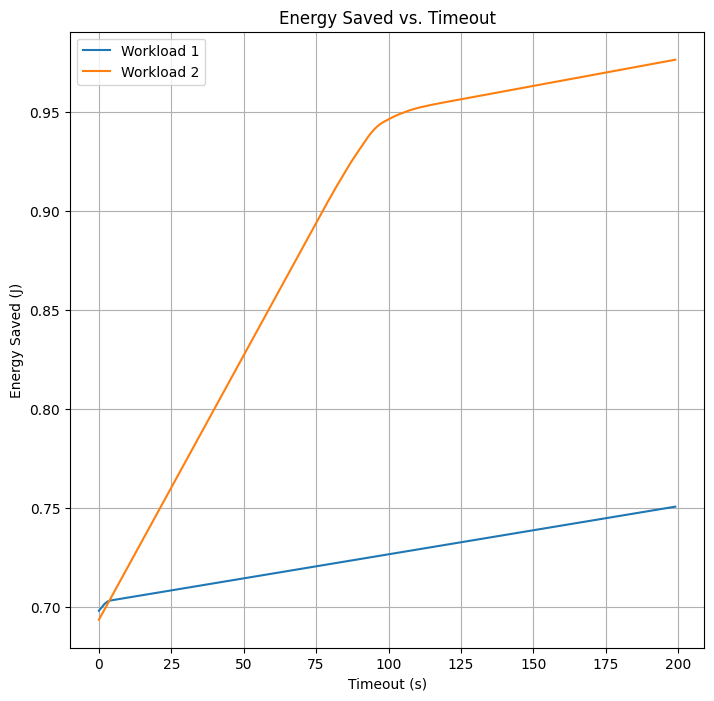

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104


<Figure size 640x480 with 0 Axes>

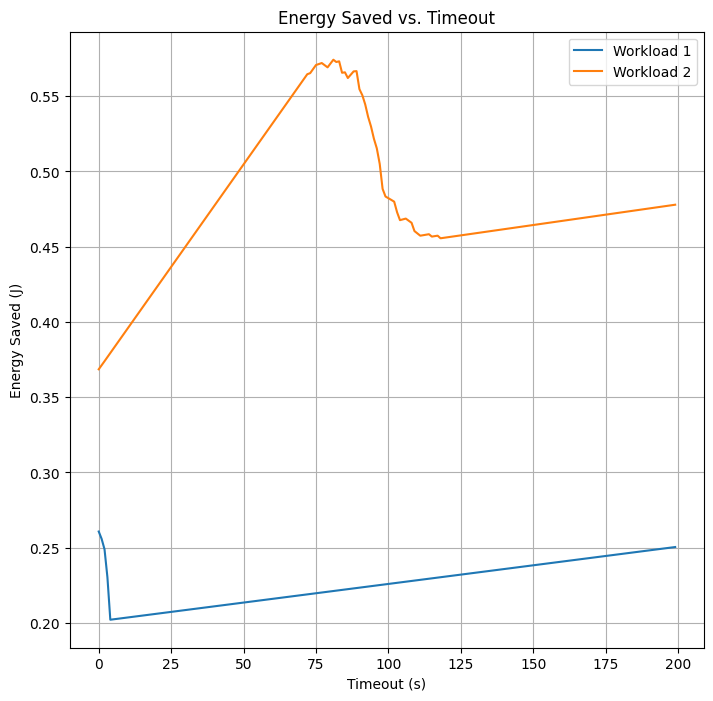

<Figure size 640x480 with 0 Axes>

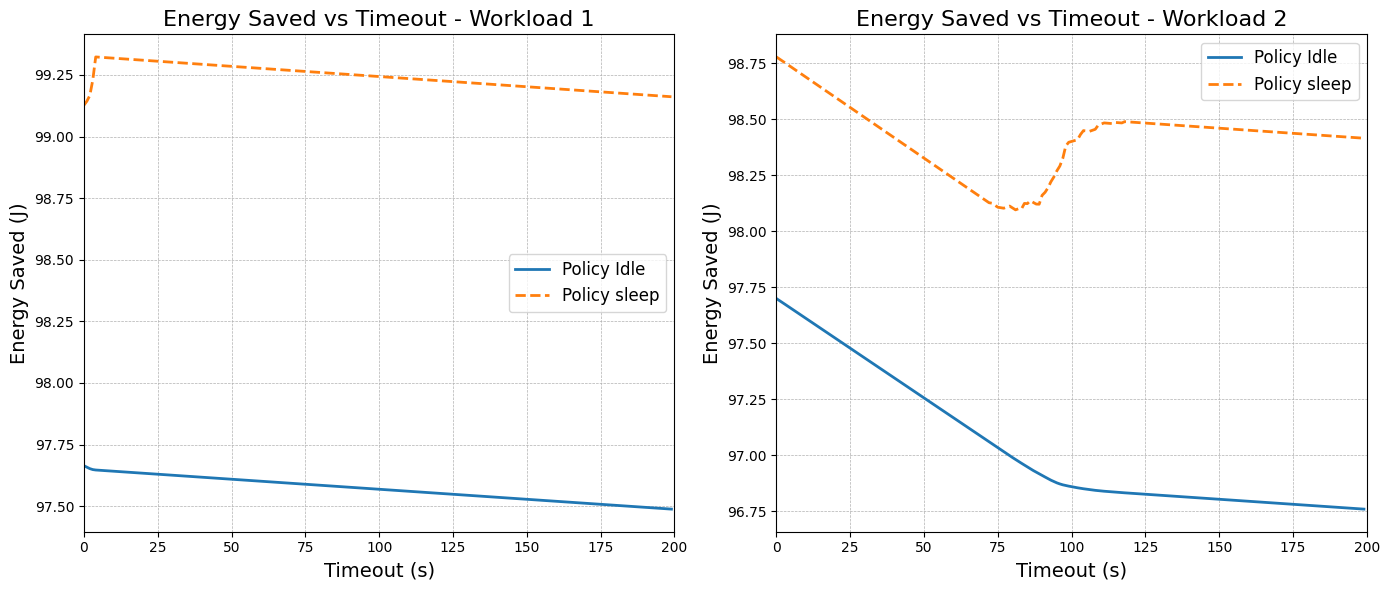

In [99]:


#plotto la PDF dei tempi di inattività e la CDF
plot_break_even_effect(w1_idle_times, Tbe, Pon, Poff, Ttr)
plot_break_even_effect(w2_idle_times, Tbe, Pon, Poff, Ttr)

plot_saved_energy_timeout('i')
plot_saved_energy_timeout('s')
plot_power_timeout('i')
plot_power_timeout('s')
plot_energy_saved_idle_vs_sleep_both()


In [100]:
import re
def extract_energy_saved(output):
    """
    Estrae i valori dell'energia dal messaggio di output e calcola l'energia salvata.
    L'output deve contenere una stringa del tipo:
      [sim] Tot. Energy w/o DPM = <val1>J, Tot. Energy w DPM = <val2>J
    Restituisce energy_saved = val1 - val2.
    """
    # Pattern per trovare i due valori energetici (con eventuali spazi)
    pattern = r"Tot\. Energy w/o DPM\s*=\s*([\d\.]+)J,\s*Tot\. Energy w DPM\s*=\s*([\d\.]+)J"
    match = re.search(pattern, output)
    if match:
        energy_no_dpm = float(match.group(1))
        energy_dpm = float(match.group(2))
        savings = (1 - energy_dpm / energy_no_dpm) * 100
        print(savings)
        return savings
    else:
        print("Impossibile estrarre i valori energetici dall'output.")
        return None


In [101]:
def extract_delay(output):
    """
    Estrae i valori dell'energia dal messaggio di output e calcola l'energia salvata.
    L'output deve contenere una stringa del tipo:
      [sim] Tot. Energy w/o DPM = <val1>J, Tot. Energy w DPM = <val2>J
    Restituisce energy_saved = val1 - val2.
    """
    pattern = r"Timeout waiting time\s*=\s*([\d\.]+)s"
    match = re.search(pattern, output, re.DOTALL)
    if match:
        delay = float(match.group(1))
        return delay
    else:
        print("Impossibile estrarre i valori energetici dall'output.")
        return None

In [102]:
import os
def run_policy_simulation(policy_flag, params):
    """
    Costruisce il comando per la policy history specificata e lo esegue num_runs volte.
    
    policy_flag: deve essere una delle seguenti stringhe: "-ha", "-hi", "-he"
    params: un dizionario contenente i parametri necessari per il flag:
        • Per "-ha" e "-hi": {'thresh0', 'thresh1'}
        • Per "-he": {'alpha', 'thresh0', 'thresh1'}
    """
    base_command = "./dpm_simulator -psm psm.txt "
    if policy_flag in ["-ha", "-hi"]:
        command = f"{base_command}{policy_flag} {params['thresh0']} {params['thresh1']} "
    elif policy_flag == "-he":
        command = f"{base_command}{policy_flag} {params['alpha']} {params['thresh0']} {params['thresh1']} "
    elif policy_flag == "-or":
        command = f"{base_command}{policy_flag} "
    else:
        raise ValueError("Policy flag non riconosciuto.")
    
    command += "-wl ../workloads/workload_1.txt"
    
    print(f"Eseguo comando: {command}")
    os.chdir("/home/tommasomontedoro/emiot/emiot-lab/lab1/dpm-simulator")
    stream = os.popen(command)
    output = stream.read()
    #delay = extract_delay(output)
    energy_saved = extract_energy_saved(output)
    
    
    return energy_saved

In [103]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

def plot_threshold2_savings(data: list):
     # Ordina i dati in base al threshold
    sorted_data = sorted(data, key=lambda x: x[0])
    thresholds = [item[0] for item in sorted_data]
    energies = [item[1] for item in sorted_data]
    
    # Trova il punto con il massimo valore di energy
    max_data = max(data, key=lambda x: x[1])
    x_point, y_point = max_data

    plt.figure(figsize=(8,6))
    # Disegna la curva (line plot) con marker
    plt.scatter(thresholds, energies, color='blue', label="Energy Savings")
    # Annotazione: evidenzia il punto con il massimo valore di energy
    plt.annotate(f"({x_point}, {y_point:.2f})", 
                 xy=(x_point, y_point), 
                 xytext=(0,10),           # offset in pixel
                 textcoords="offset points", 
                 ha='center',
                 arrowprops=dict(arrowstyle="->", color="red"))
    
    plt.xlabel("Alpha", fontsize=14)
    plt.ylabel("Energy Savings (J)", fontsize=14)
    plt.title("Energy Savings vs. Alpha", fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()
    

In [104]:
import numpy as np
import matplotlib.pyplot as plt

def compute_pareto_front(results):
    """
    Dato un elenco di tuple (alpha, thresh0, thresh1, energy_saved),
    raggruppa i risultati per alpha e seleziona, per ogni alpha, la combinazione
    con il massimo energy_saved.
    
    Restituisce una lista di tuple (alpha, thresh0, thresh1, best_energy_saved).
    """
    # Raggruppa per alpha
    groups = {}
    for (a, t0, t1, energy) in results:
        if a not in groups:
            groups[a] = []
        groups[a].append((t0, t1, energy))
    
    pareto_points = []
    for a, group in groups.items():
        # Ordina il gruppo per energy_saved in ordine decrescente (maggior è meglio)
        group_sorted = sorted(group, key=lambda x: x[2], reverse=True)
        best = group_sorted[0]  # il primo ha il valore massimo di energy saved per quell'alpha
        pareto_points.append((a, best[0], best[1], best[2]))
    return pareto_points

def plot_pareto_curve(pareto_points):
    """
    Plotta una curva in cui l'asse x è alpha e l'asse y il best energy saved
    (ovvero il punto Pareto per ciascun alpha).
    """
    pareto_points = sorted(pareto_points, key=lambda x: x[0])
    alphas = [p[0] for p in pareto_points]
    energies = [p[3] for p in pareto_points]
    
    plt.figure(figsize=(8,6))
    plt.plot(alphas, energies, marker='o', linestyle='-', color='red', label='Pareto front')
    for p in pareto_points:
        plt.annotate(f"({p[1]}, {p[2]})", 
                     xy=(p[0], p[3]), xytext=(5,5),
                     textcoords='offset points', fontsize=10, color='red')
    plt.xlabel("Alpha", fontsize=14)
    plt.ylabel("Energy Savings (J)", fontsize=14)
    plt.title("Pareto Curve for Exponential Policy", fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

In [105]:
import itertools

# Definisce i candidati per thresh0 e thresh1
candidate_th1 = np.arange(0, 505, 5)
results_ha = []  # lista per memorizzare, per policy -ha, ((thresh0, thresh1), energy)
results_hi = []  # stessa cosa per policy -hi
results_he = []  # per policy -he
pareto_he = []  # per policy -he
def grid_search_all_policies():
    # Grid search per le policy -ha e -hi
    for policy in ["-ha", "-hi"]:
        for t1 in candidate_th1:
            params = {'thresh0': 0.0, 'thresh1': float(t1)}
            energy = run_policy_simulation(policy, params)  # si assume questa funzione restituisca energy
            print(f"Policy {policy} with thresh0={0.0} and thresh1={t1} -> Energy saved: {energy} J")
            if policy == "-ha":
                results_ha.append((t1, energy))
            else:
                results_hi.append((t1, energy))
    
    print("\n")
    num_ha = len(results_ha)
    num_hi = len(results_hi)
    print(f"Policy -ha: {num_ha} combinazioni, Policy -hi: {num_hi} combinazioni")
    #plot_heatmap_from_results("-ha", sorted_policies_ha)
    plot_threshold2_savings(results_ha)
    #plot_heatmap_from_results("-hi", sorted_policies_hi)
    plot_threshold2_savings(results_hi)

    max_hi = max(results_hi, key=lambda x: x[1])
    print(f"Massimo risparmio per policy -hi: {max_hi}")
    max_ha = max(results_ha, key=lambda x: x[1])
    print(f"Massimo risparmio per policy -ha: {max_ha}")
    return max_ha, max_hi
    

def grid_search_he_policy():
    # Grid search per la policy -he: include anche il parametro alpha
    candidate_alpha = np.arange(0.1, 1.0, 0.1)  # da 0.1 a 1.0 con step 0.1
    w1_thresholds = np.arange(0,150,5)
    #w2_thresholds = np.concatenate((np.arange(0, 60, 10), np.arange(60, 120, 1), np.arange(120, 150, 10)))
    for a in candidate_alpha:
        for t in w1_thresholds:
            params = {'alpha': float(a), 'thresh0': float(0.0), 'thresh1': float(t)}
            energy = run_policy_simulation("-he", params)
            print(f"Policy -he with alpha={a:.1f}, thresh0={0.0}, thresh1={t} -> Energy saved: {energy} J")
            results_he.append((a, energy))
            pareto_he.append((a, 0.0, t, energy))
    plot_threshold2_savings(results_he)
    pareto_points = compute_pareto_front(pareto_he)
    plot_pareto_curve(pareto_points)
    max_he = max(results_he, key=lambda x: x[1])
    return max_he


Eseguo comando: ./dpm_simulator -psm psm.txt -ha 0.0 0.0 -wl ../workloads/workload_1.txt
99.14090926561316
Policy -ha with thresh0=0.0 and thresh1=0 -> Energy saved: 99.14090926561316 J
Eseguo comando: ./dpm_simulator -psm psm.txt -ha 0.0 5.0 -wl ../workloads/workload_1.txt
99.3330140633163
Policy -ha with thresh0=0.0 and thresh1=5 -> Energy saved: 99.3330140633163 J
Eseguo comando: ./dpm_simulator -psm psm.txt -ha 0.0 10.0 -wl ../workloads/workload_1.txt
99.3330140633163
Policy -ha with thresh0=0.0 and thresh1=10 -> Energy saved: 99.3330140633163 J
Eseguo comando: ./dpm_simulator -psm psm.txt -ha 0.0 15.0 -wl ../workloads/workload_1.txt
99.3330140633163
Policy -ha with thresh0=0.0 and thresh1=15 -> Energy saved: 99.3330140633163 J
Eseguo comando: ./dpm_simulator -psm psm.txt -ha 0.0 20.0 -wl ../workloads/workload_1.txt
99.3330140633163
Policy -ha with thresh0=0.0 and thresh1=20 -> Energy saved: 99.3330140633163 J
Eseguo comando: ./dpm_simulator -psm psm.txt -ha 0.0 25.0 -wl ../workloa

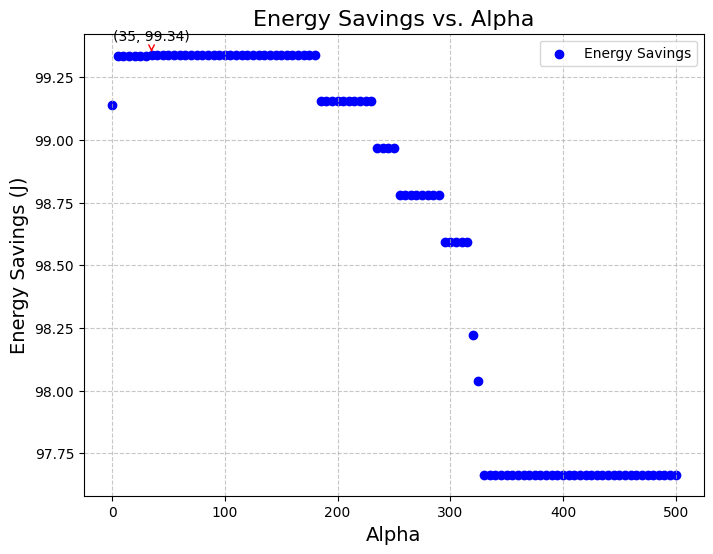

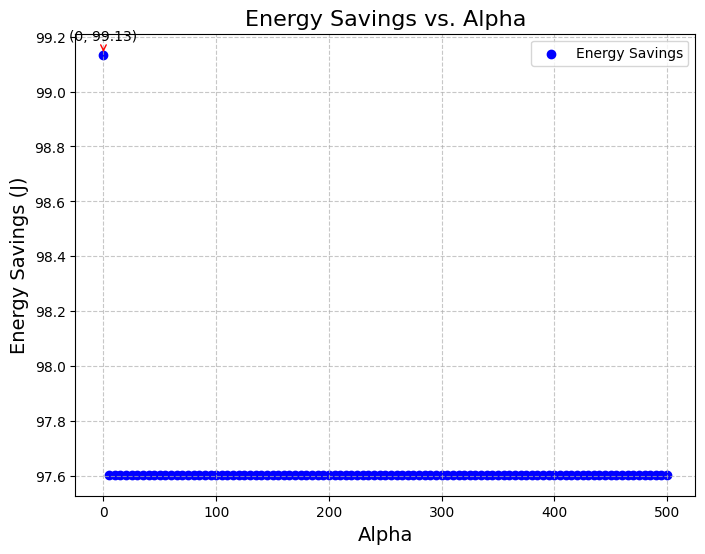

Massimo risparmio per policy -hi: (np.int64(0), 99.13405812162145)
Massimo risparmio per policy -ha: (np.int64(35), 99.33963107038414)
Eseguo comando: ./dpm_simulator -psm psm.txt -he 0.1 0.0 0.0 -wl ../workloads/workload_1.txt
99.1275752618446
Policy -he with alpha=0.1, thresh0=0.0, thresh1=0 -> Energy saved: 99.1275752618446 J
Eseguo comando: ./dpm_simulator -psm psm.txt -he 0.1 0.0 5.0 -wl ../workloads/workload_1.txt
99.14749570950899
Policy -he with alpha=0.1, thresh0=0.0, thresh1=5 -> Energy saved: 99.14749570950899 J
Eseguo comando: ./dpm_simulator -psm psm.txt -he 0.1 0.0 10.0 -wl ../workloads/workload_1.txt
99.14749570950899
Policy -he with alpha=0.1, thresh0=0.0, thresh1=10 -> Energy saved: 99.14749570950899 J
Eseguo comando: ./dpm_simulator -psm psm.txt -he 0.1 0.0 15.0 -wl ../workloads/workload_1.txt
99.14749570950899
Policy -he with alpha=0.1, thresh0=0.0, thresh1=15 -> Energy saved: 99.14749570950899 J
Eseguo comando: ./dpm_simulator -psm psm.txt -he 0.1 0.0 20.0 -wl ../wo

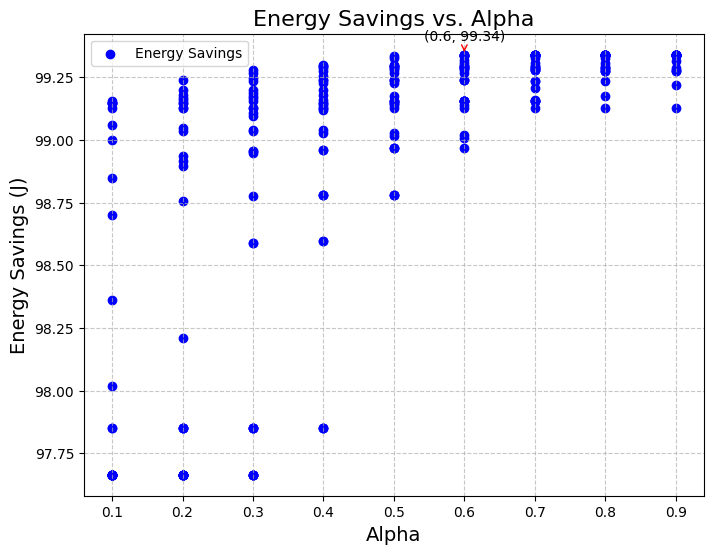

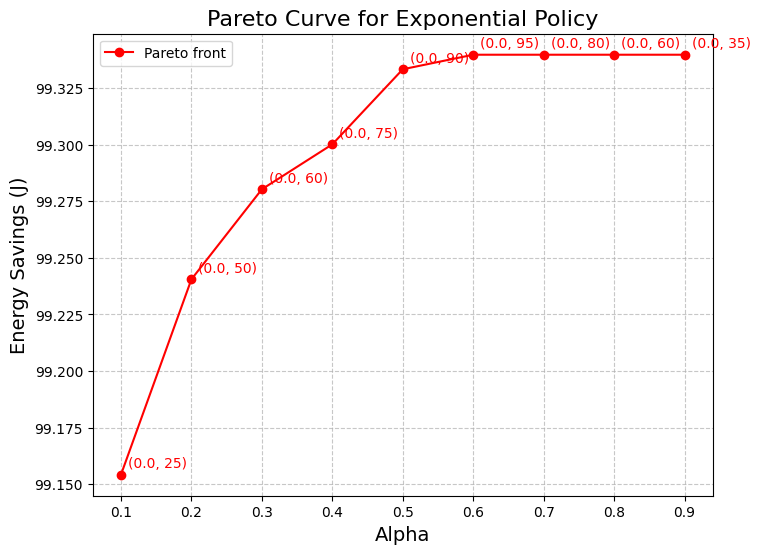

Eseguo comando: ./dpm_simulator -psm psm.txt -or -wl ../workloads/workload_1.txt
99.33973266649124
Massimo risparmio per policy -orcl: 99.33973266649124


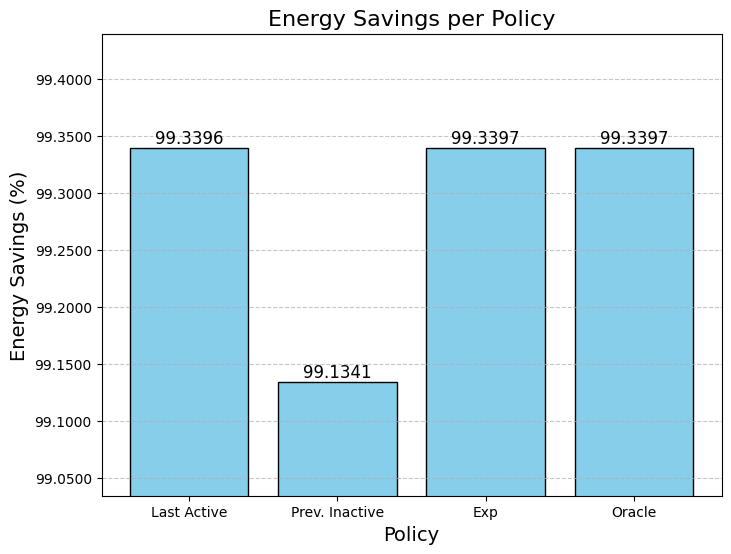

In [106]:
max_ha, max_hi = grid_search_all_policies()
max_he = grid_search_he_policy()
oracle_val = run_policy_simulation("-or", _)
print(f"Massimo risparmio per policy -orcl: {oracle_val}")

import matplotlib.pyplot as plt

# Dati di esempio: nomi delle policy e percentuali di savings
policy_names = ["Last Active", "Prev. Inactive", "Exp", "Oracle"]
# Valori di energy savings espressi in percentuale (es. 12.34% = 12.34)
savings = [max_ha[1], max_hi[1], max_he[1], oracle_val]

plt.figure(figsize=(8,6))
bars = plt.bar(policy_names, savings, color='skyblue', edgecolor='black')

plt.xlabel("Policy", fontsize=14)
plt.ylabel("Energy Savings (%)", fontsize=14)
plt.title("Energy Savings per Policy", fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Imposta l'intervallo dell'asse y in modo da evidenziare le piccole differenze.
plt.ylim(min(savings) - 0.1, max(savings) + 0.1)

# Formatta i tick dell'asse y per mostrare 4 cifre decimali
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f"{x:.4f}"))

# Aggiungi annotazioni sopra ogni barra con il valore
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f"{yval:.4f}", va='bottom', ha='center', fontsize=12)

plt.show()


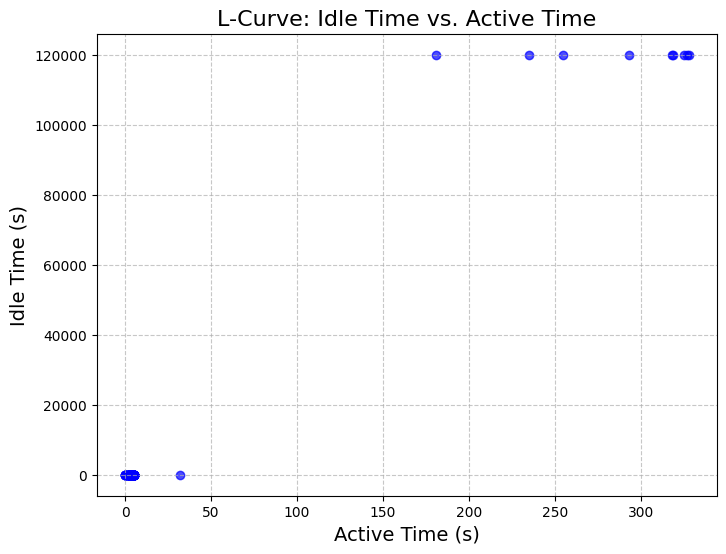

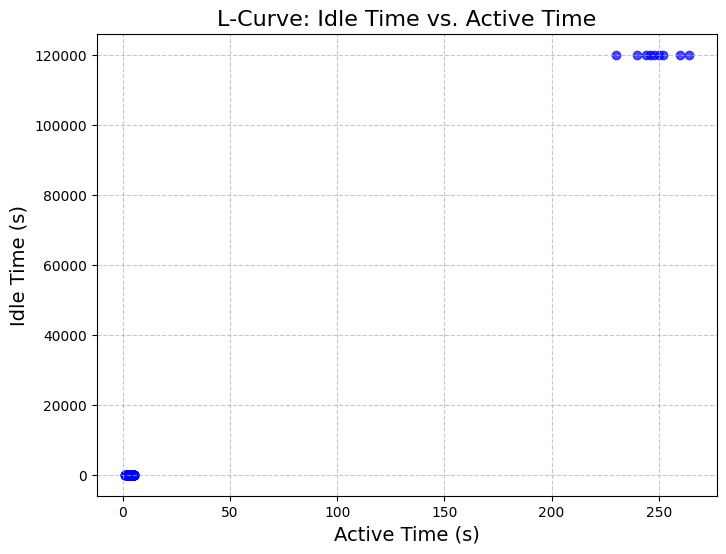

In [107]:
import numpy as np
import matplotlib.pyplot as plt

def load_workload(file_path):
    """
    Legge il file workload (ogni riga: "arrival_time duration")
    e restituisce una lista di tuple (arrival_time, duration).
    """
    workload = []
    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            if len(parts) < 2:
                continue
            try:
                arrival = float(parts[0])
                duration = float(parts[1])
                workload.append((arrival, duration))
            except ValueError:
                print(f"Valore non valido nella riga: {line}")
                continue
    return workload

def compute_active_idle(workload):
    """
    Data una lista di task (arrival, duration) ordinata per arrival,
    per ogni task (eccetto l'ultimo) calcola:
      - active time: la durata del task (duration)
      - idle time: la differenza tra l'arrivo del task successivo e (arrival + duration) del task corrente
    Restituisce due liste: active_times e idle_times.
    """
    # Assicuriamoci che i task siano ordinati per arrivaltime
    workload = sorted(workload, key=lambda x: x[0])
    active_times = []
    idle_times = []
    for i in range(len(workload)-1):
        arrival, duration = workload[i]
        active_times.append(duration)
        end_time = arrival + duration
        next_arrival, _ = workload[i+1]
        idle = next_arrival - end_time
        idle_times.append(idle)
    return active_times, idle_times

def plot_l_curve(file_path):
    """
    Carica il file workload, calcola i valori di active time e idle time,
    e plotta la "L-curve" con idle time vs. active time.
    """
    workload = load_workload(file_path)
    if not workload:
        print("Nessun workload trovato.")
        return
    active_times, idle_times = compute_active_idle(workload)
    
    plt.figure(figsize=(8,6))
    plt.scatter(active_times, idle_times, color='blue', alpha=0.7, marker='o')
    plt.xlabel("Active Time (s)", fontsize=14)
    plt.ylabel("Idle Time (s)", fontsize=14)
    plt.title("L-Curve: Idle Time vs. Active Time", fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.7)
    # Aggiunge la linea orizzontale per Tbe (il break-even time)
    #plt.axhline(y=0.8, color='red', linestyle='--', linewidth=2, label=f"Tbe = {}s")
      # Aggiunge la linea verticale per threshold
    #plt.axvline(x=5, color='green', linestyle='--', linewidth=2, label=f"Threshold = {5}s")
    plt.show()

# Esempio di utilizzo
if __name__ == "__main__":
    file_path = "../workloads/workload_1.txt"  # Sostituisci con il percorso corretto
    plot_l_curve(file_path)
    file_path = "../workloads/workload_2.txt"  # Sostituisci con il percorso corretto
    plot_l_curve(file_path)
